<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [2]:
!pip install datasets

Импорт необходимых библиотек

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk
import string

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/rekut.na/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [6]:
# Загрузим датасет
dataset = load_dataset('imdb')

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [7]:
sentences = []
word_threshold = 32

# sentences = [sentence for sentence in (sent_tokenize(item) for item in dataset['train']['text'])]

for item in tqdm(dataset['train']['text'][::2]):
    sentences.extend([sentence.lower() for sentence in sent_tokenize(item)])

  0%|          | 0/12500 [00:00<?, ?it/s]

In [8]:
print("Всего предложений:", len(sentences))

Всего предложений: 135417


Посчитаем для каждого слова его встречаемость.

In [9]:
words = Counter()

for sentence in tqdm(sentences):
    sentence = word_tokenize(sentence.translate(str.maketrans('', '', string.punctuation)))

    if len(sentence) > word_threshold:
        continue

    for word in sentence:
        words[word] += 1

  0%|          | 0/135417 [00:00<?, ?it/s]

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [10]:
vocab = set()
cnt_threshold = 20

vocab.add('<unk>')
vocab.add('<bos>')
vocab.add('<eos>')
vocab.add('<pad>')

for word in words:
    if words[word] > cnt_threshold:
        vocab.add(word)

vocab_size = len(vocab)

print('vocab size: ', len(vocab))

vocab size:  5470


In [11]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab

### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [12]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [13]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = []

        sentence = word_tokenize(self.data[idx].translate(
            str.maketrans('', '', string.punctuation)))

        tokenized_sentence.append(self.bos_id)
        tokenized_sentence.extend([word2ind.get(word, self.unk_id) for word in sentence])
        tokenized_sentence.append(self.eos_id)

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [14]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [15]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 32

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [16]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [25]:
def train_model(model, optimizer, criterion) -> List:
    num_epoch = 8
    history_losses = []
    model.train()

    for epoch in range(num_epoch):
        epoch_loss = np.asarray([])

        for i, batch in enumerate(tqdm(train_dataloader)):
            optimizer.zero_grad()
            predictions = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(predictions.cpu(), batch['target_ids'].flatten().cpu())
            loss.backward()
            optimizer.step()
            epoch_loss = np.concatenate((epoch_loss, np.asarray([loss.item()])))
            torch.cuda.empty_cache()
        
        history_losses.append(np.mean(epoch_loss))

    return history_losses

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

Для начала при схожих параметрах, определим оптимальный тип RNN: Vanilla RNN, LSTM или GRU. В качестве классификатора возьмем 2 полносвязных слоя с функцией активации RELU и dropout = 0.1:

In [ ]:
# class LanguageModel_rnn(nn.Module):
#     def __init__(
#         self,
#         hidden_dim: int,
#         vocab_size: int,
#         classification_hidden_dim: int = 256,
#         num_layers: int = 1,
#         dropout: float = 0.0
#         ):
#         super().__init__()

#         self.embedding = nn.Embedding(vocab_size, hidden_dim)
#         self.num_layers = num_layers
#         self.hidden_dim = hidden_dim

#         assert dropout < 1.0, "invalid dropout value"
#         self.rnn = nn.RNN(input_size=hidden_dim,
#                           hidden_size=hidden_dim,
#                           batch_first=True,
#                           num_layers=num_layers)

#         self.classifier = nn.Sequential(nn.ReLU(),
#                                         nn.Linear(hidden_dim, classification_hidden_dim),
#                                         nn.Dropout(p=dropout),
#                                         nn.ReLU(),
#                                         nn.Linear(classification_hidden_dim, vocab_size))


#     def forward(self, input_batch) -> torch.Tensor:
#         batch_size = len(input_batch)
#         h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)

#         embeddings = self.embedding(input_batch)
#         output, _ = self.rnn(embeddings, h_0)

#         prediction = self.classifier(output)
#         return prediction

In [18]:
class LanguageModel_rnn(nn.Module):
    def __init__(
        self,
        rnn_type: str,
        hidden_dim: int,
        batch_size: int = 128,
        num_layers: int = 1,
        classifier: nn.Module = nn.Sequential(
            nn.ReLU(),
            nn.Linear(256, vocab_size)
            )
        ):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.batch_size = batch_size

        if rnn_type in ['LSTM', 'GRU']:
            self.rnn = getattr(nn, rnn_type)(
                input_size=hidden_dim,
                hidden_size=hidden_dim,
                batch_first=True,
                num_layers=num_layers
                )
        else:
            self.rnn = nn.RNN(
                input_size=hidden_dim,
                hidden_size=hidden_dim,
                batch_first=True,
                num_layers=num_layers
            )

        self.classifier = classifier

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)

        h_0 = torch.zeros(self.num_layers, input_batch.size(0),
                          self.hidden_dim).to(input_batch.device)
        if isinstance(self.rnn, nn.LSTM):
            c_0 = torch.zeros(self.num_layers, input_batch.size(0),
                              self.hidden_dim).to(input_batch.device)
            output, _ = self.rnn(embeddings, (h_0, c_0))
        else:
            output, _ = self.rnn(embeddings, h_0)

        prediction = self.classifier(output)
        return prediction


In [26]:
hidden_dim = 256
classification_hidden_dim = 256

classifier_exp_1 = nn.Sequential(
    nn.ReLU(),
    nn.Linear(hidden_dim, classification_hidden_dim),
    nn.Dropout(p=0.1),
    nn.ReLU(),
    nn.Linear(classification_hidden_dim, vocab_size)
    )

model_rnn_1 = LanguageModel_rnn(
    rnn_type='RNN',
    hidden_dim=hidden_dim,
    batch_size=batch_size,
    num_layers=3,
    classifier=classifier_exp_1
    ).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model_rnn_1.parameters())

In [27]:
model_rnn_1_hist = train_model(model_rnn_1, optimizer, criterion)

  0%|          | 0/3386 [00:00<?, ?it/s]

  0%|          | 0/3386 [00:00<?, ?it/s]

  0%|          | 0/3386 [00:00<?, ?it/s]

  0%|          | 0/3386 [00:00<?, ?it/s]

  0%|          | 0/3386 [00:00<?, ?it/s]

  0%|          | 0/3386 [00:00<?, ?it/s]

  0%|          | 0/3386 [00:00<?, ?it/s]

  0%|          | 0/3386 [00:00<?, ?it/s]

In [28]:
PATH = 'model_rnn_1.pth'

torch.save(model_rnn_1.state_dict(), PATH)

Теперь рассмотрим LSTM архитектуру:

In [29]:
model_rnn_2 = LanguageModel_rnn(
    rnn_type='LSTM',
    hidden_dim=hidden_dim,
    batch_size=batch_size,
    num_layers=3,
    classifier=classifier_exp_1
    ).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model_rnn_2.parameters())

In [30]:
model_rnn_2_hist = train_model(model_rnn_2, optimizer, criterion)

PATH = 'model_rnn_2.pth'
torch.save(model_rnn_2.state_dict(), PATH)

  0%|          | 0/3386 [00:00<?, ?it/s]

  0%|          | 0/3386 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/3386 [00:00<?, ?it/s]

  0%|          | 0/3386 [00:00<?, ?it/s]

  0%|          | 0/3386 [00:00<?, ?it/s]

  0%|          | 0/3386 [00:00<?, ?it/s]

  0%|          | 0/3386 [00:00<?, ?it/s]

GRU архитектура:

In [31]:
model_rnn_3 = LanguageModel_rnn(
    rnn_type='GRU',
    hidden_dim=hidden_dim,
    batch_size=batch_size,
    num_layers=3,
    classifier=classifier_exp_1
    ).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model_rnn_3.parameters())

In [32]:
model_rnn_3_hist = train_model(model_rnn_3, optimizer, criterion)

PATH = 'model_rnn_3.pth'
torch.save(model_rnn_3.state_dict(), PATH)

  0%|          | 0/3386 [00:00<?, ?it/s]

  0%|          | 0/3386 [00:00<?, ?it/s]

  0%|          | 0/3386 [00:00<?, ?it/s]

  0%|          | 0/3386 [00:00<?, ?it/s]

  0%|          | 0/3386 [00:00<?, ?it/s]

  0%|          | 0/3386 [00:00<?, ?it/s]

  0%|          | 0/3386 [00:00<?, ?it/s]

  0%|          | 0/3386 [00:00<?, ?it/s]

Теперь сравним значения loss-ов во время обучения:

In [33]:
def print_losses(losses):
    for (name, values), color in zip(losses.items(), ['red', 'blue', 'green', 'yellow', '']):
        plt.plot(np.arange(len(losses[name])), losses[name], color=color, label=name)

    plt.title('Losses')
    plt.xlabel("epoch")
    plt.legend()
    plt.show()

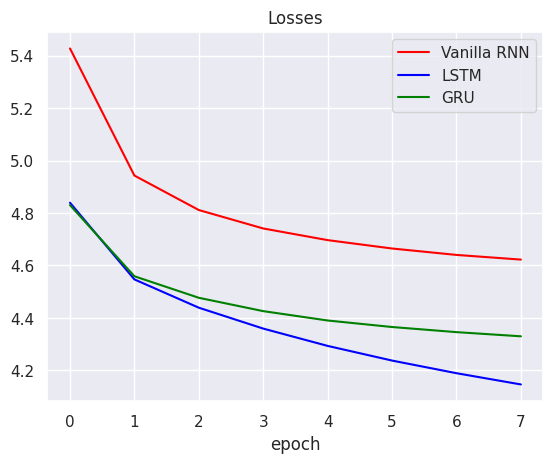

In [34]:
print_losses(
    {
    'Vanilla RNN': model_rnn_1_hist,
    'LSTM': model_rnn_2_hist,
    'GRU': model_rnn_3_hist
    }
    )

И сравним значение перплексии:

In [36]:
print("Vanilla RNN perplexity on validation dataset: ", evaluate(model_rnn_1, criterion, eval_dataloader))
print("LSTM perplexity on validation dataset: ", evaluate(model_rnn_2, criterion, eval_dataloader))
print("GRU perplexity on validation dataset: ", evaluate(model_rnn_3, criterion, eval_dataloader))

Vanilla RNN perplexity on validation dataset:  9398909.934753072
LSTM perplexity on validation dataset:  354.5421648944934
GRU perplexity on validation dataset:  74.05252377883248


Вывод:

**Генерация**

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

In [ ]:
# Проведите второй эксперимент

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.